# Classifier

## Imports

In [1]:
import sys
sys.path.append("/usr/local/lib/python3.8/dist-packages/")
sys.path.append("../")

from tqdm.notebook import tqdm
from torch.optim import AdamW
from torch.utils.data import DataLoader
from typing import Tuple
from utils import plot_acc_history, plot_loss_history, plot_window_probabilities

import numpy as np
import os
import snook.data as sd
import snook.model as sm
import torch
import torch.nn as nn

## Data Loaders

In [2]:
train        = sd.ClDataset("dataset/train/renders", "dataset/train/data")
train_loader = DataLoader(train, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)

valid        = sd.ClDataset("dataset/valid/renders", "dataset/valid/data")
valid_loader = DataLoader(valid, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

test         = sd.ClDataset("dataset/test/renders", "dataset/test/data")
test_loader  = DataLoader(test, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

## Training

In [3]:
EPOCHS = 5

In [4]:
layers    = [
    sm.Layer(  3,  16, 3),
    sm.Layer( 16,  32, 3),
    sm.Layer( 32,  64, 3),
    sm.Layer( 64, 128, 3),
    sm.Layer(128, 256, 3),
]
model     = sm.Classifier(layers, hidden=512, n_class=len(sd.COLORS) + 1, scale=0.4).cuda()
criterion = nn.CrossEntropyLoss().cuda()
optim     = AdamW(model.parameters())

In [5]:
def plot_example(dataset: sd.ReMaHeDataset) -> None:
    for i in range(10):
        window, label = dataset[i]
        logits = torch.softmax(model(window.unsqueeze(0).cuda())[0], dim=0)
        plot_window_probabilities(window, logits)

In [6]:
def step(name: str, loader: DataLoader, dataset: sd.ClDataset, is_train: bool = True) -> Tuple[float, float]:
    global model
    model = model.train() if is_train else model.eval()
    total_loss, total_acc = 0.0, 0.0
    pbar = tqdm(loader, name)
    for window, label in pbar:
        window, label = window.cuda(), label.cuda()
        if is_train:
            optim.zero_grad()
        logits = model(window)
        loss = criterion(logits, label)
        acc = (torch.argmax(logits, dim=1) == label).sum()
        if is_train:
            loss.backward()
            optim.step()
        total_loss += loss.item()
        total_acc += acc.item()
        pbar.set_postfix(loss=total_loss / len(loader), acc=total_acc / len(dataset))
    return total_loss / len(loader), total_acc / len(dataset)

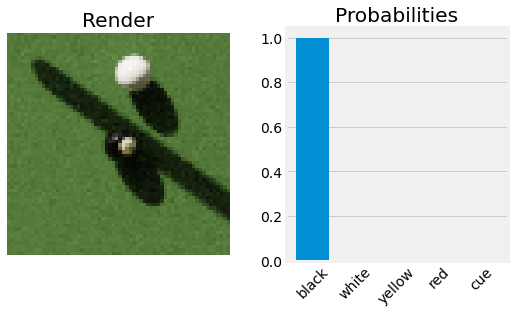

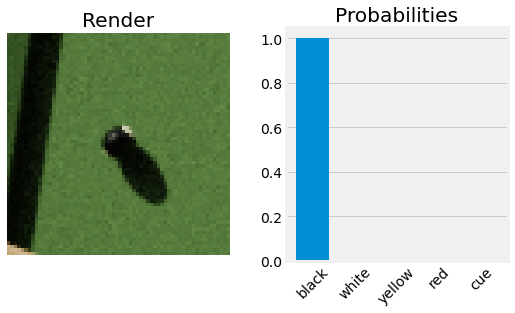

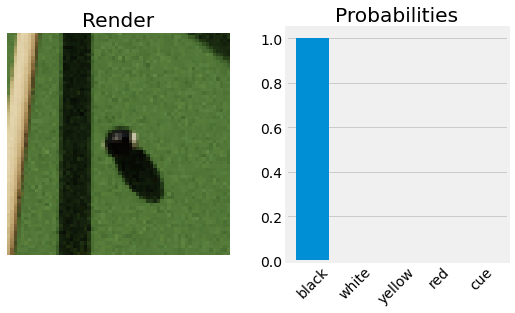

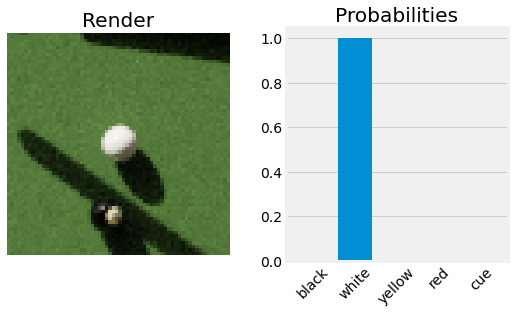

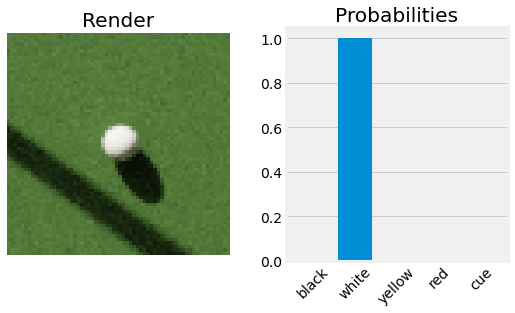

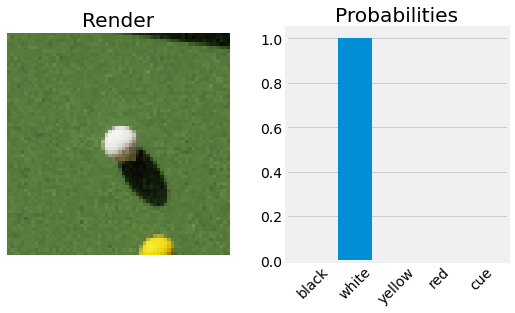

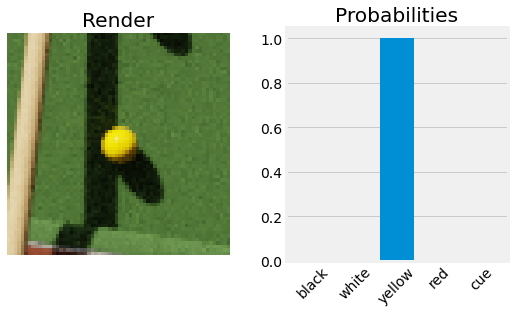

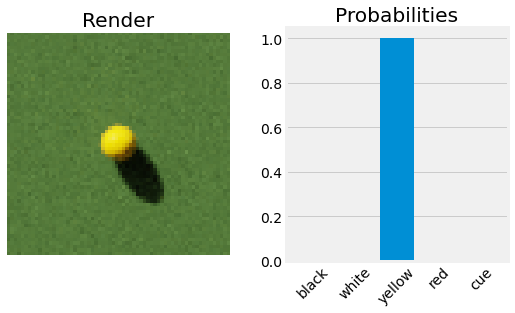

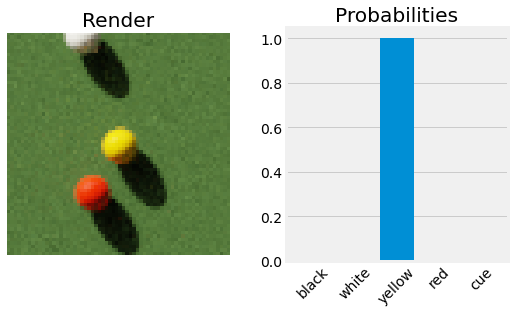

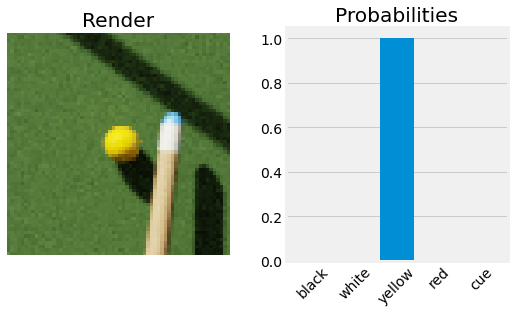

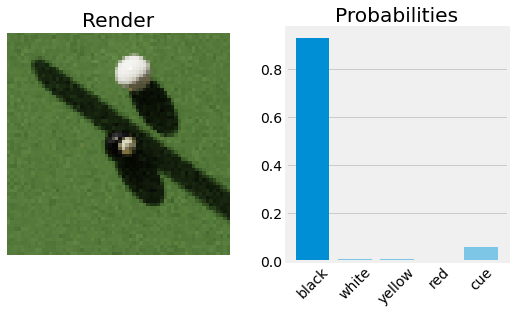

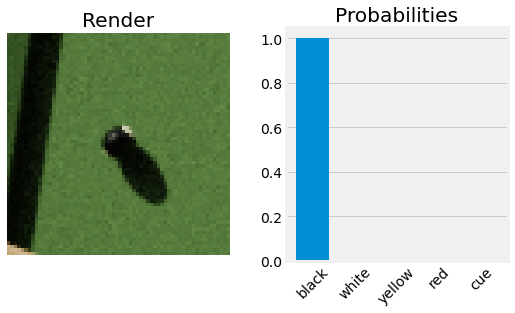

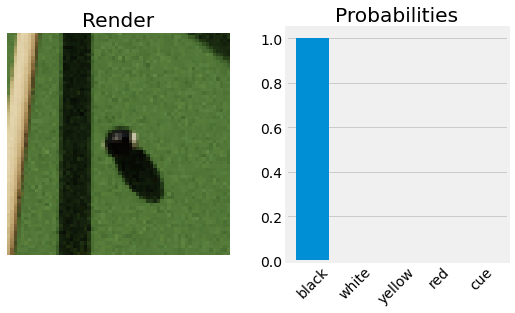

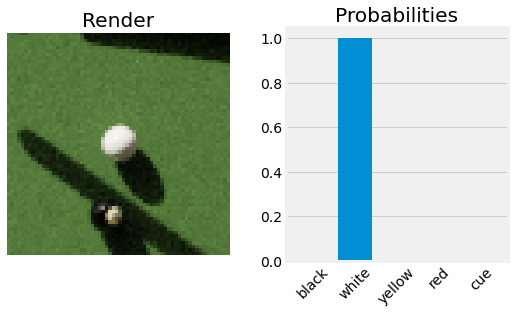

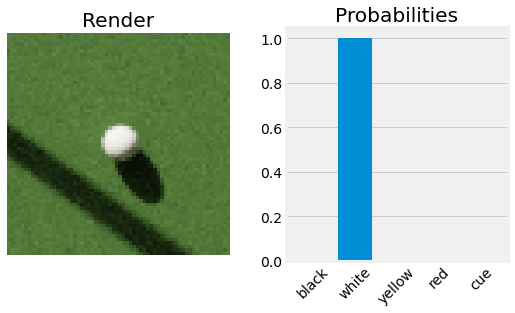

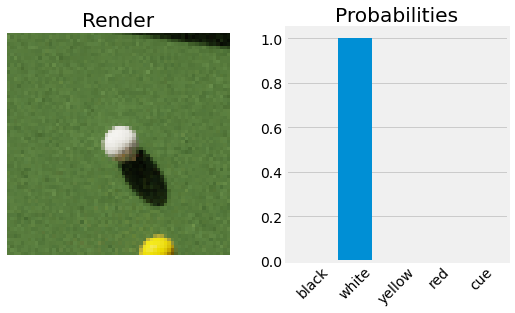

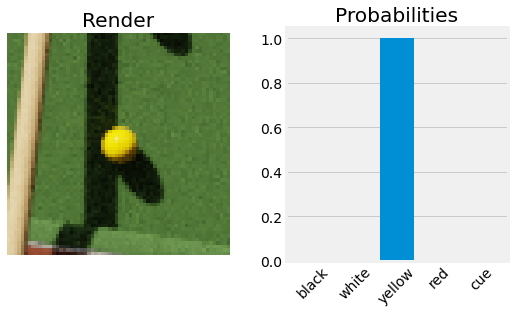

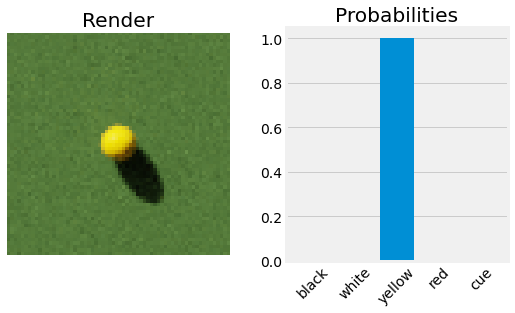

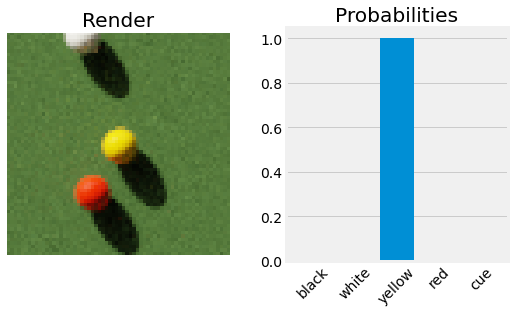

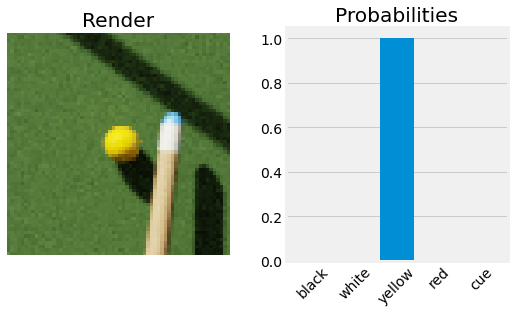

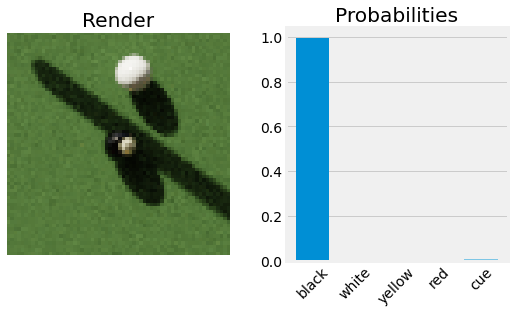

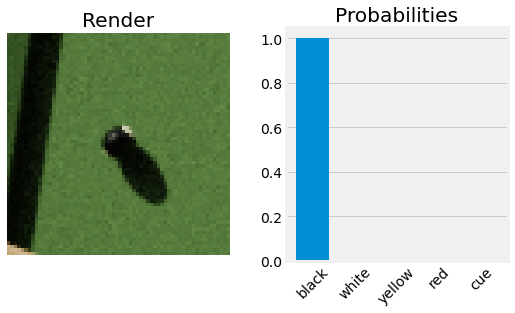

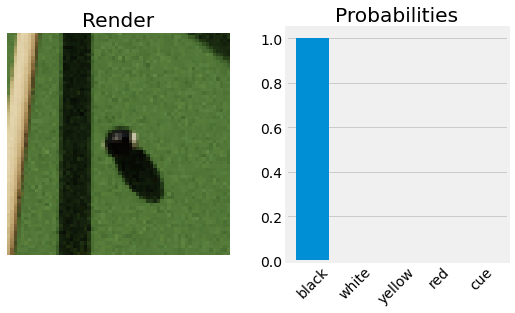

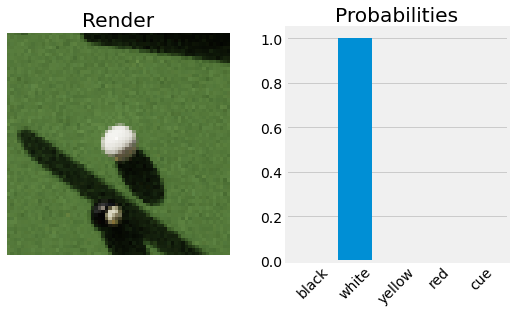

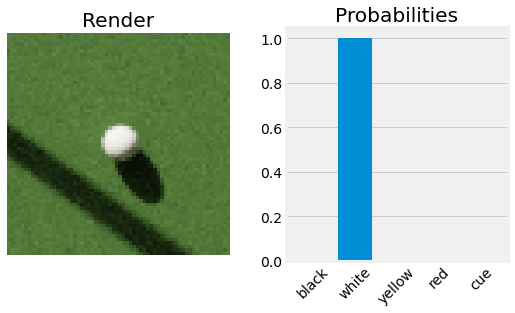

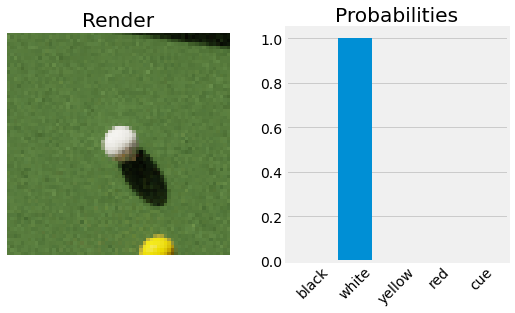

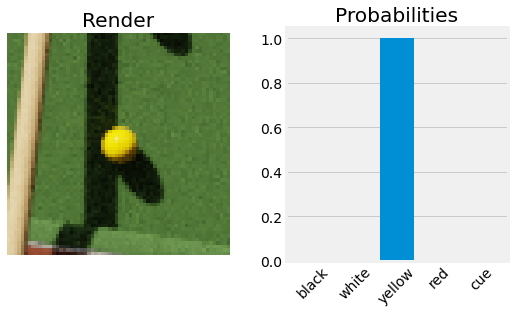

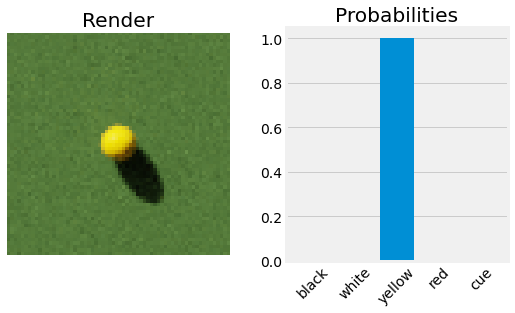

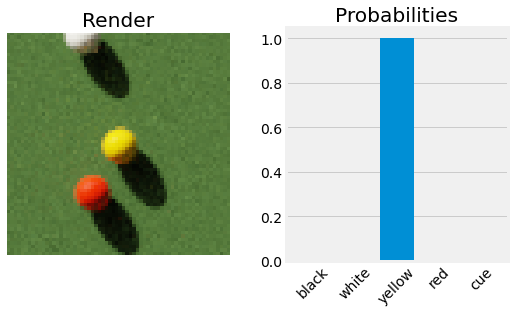

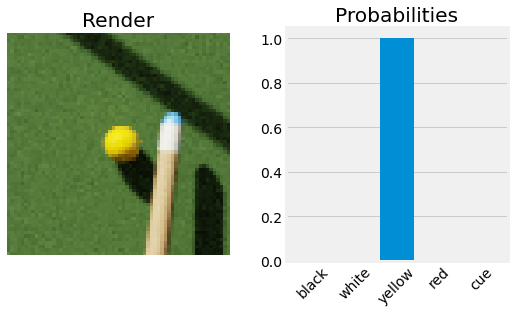

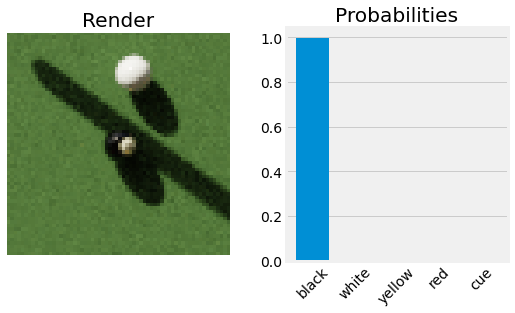

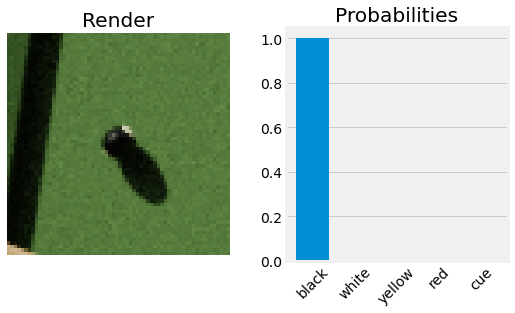

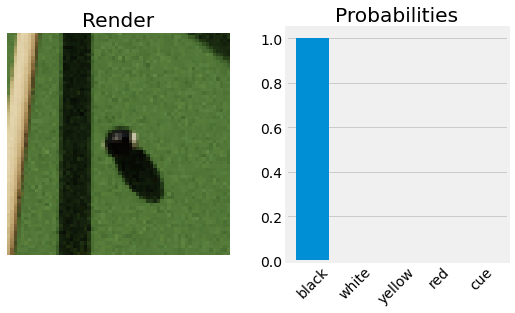

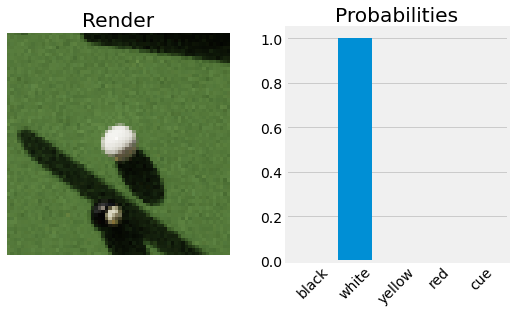

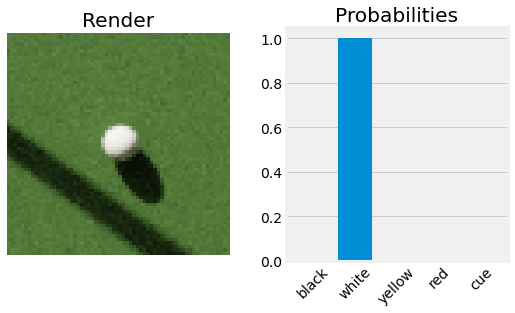

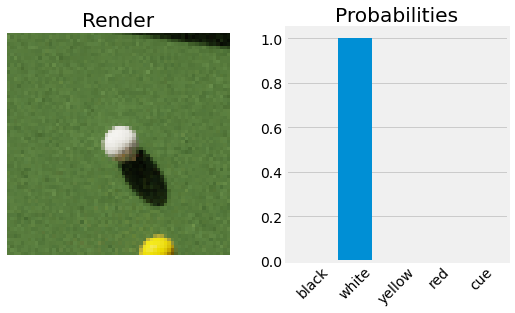

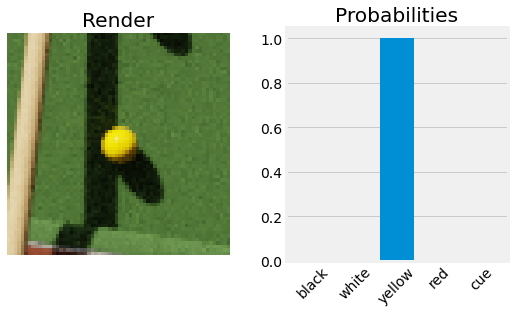

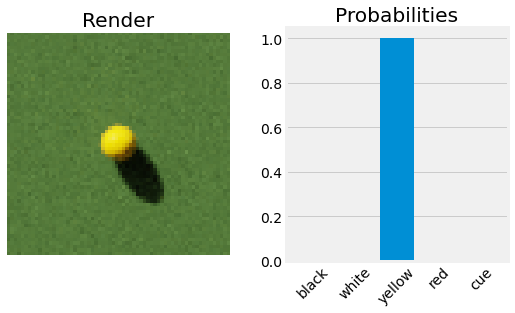

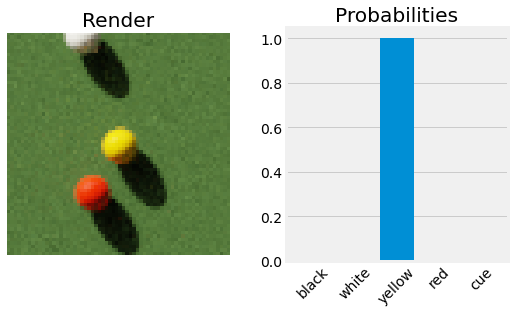

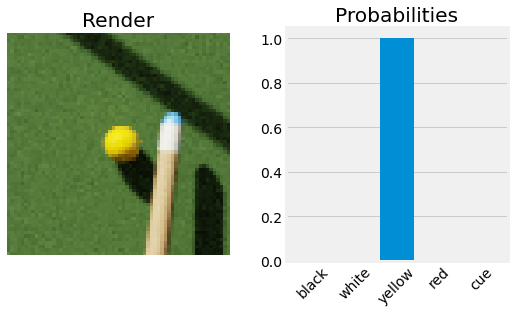

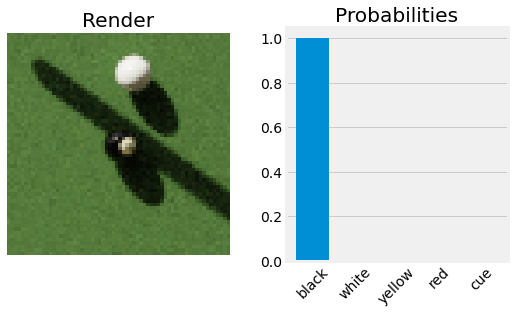

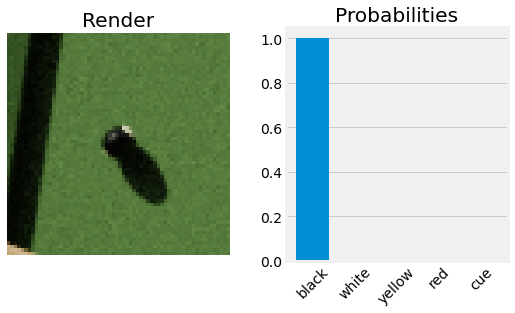

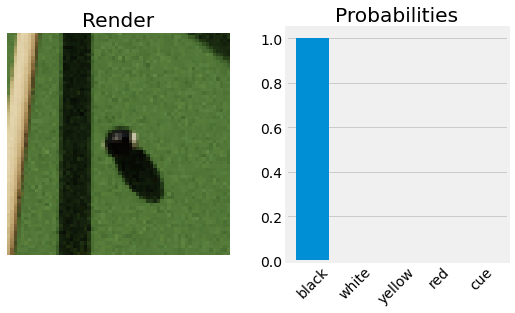

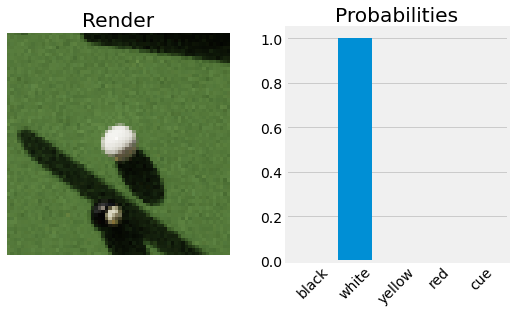

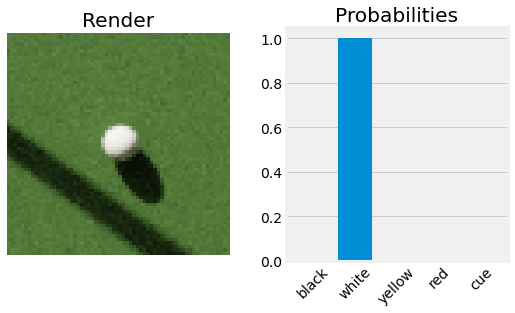

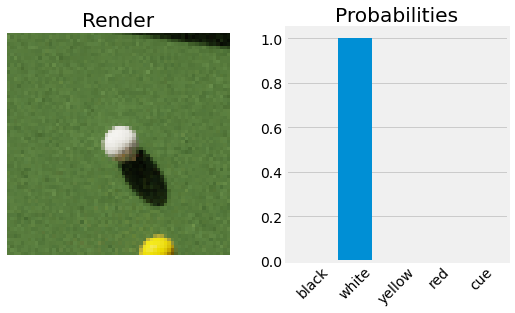

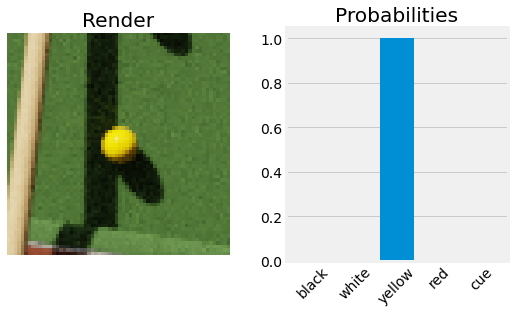

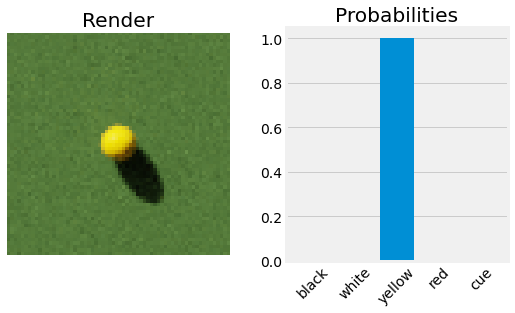

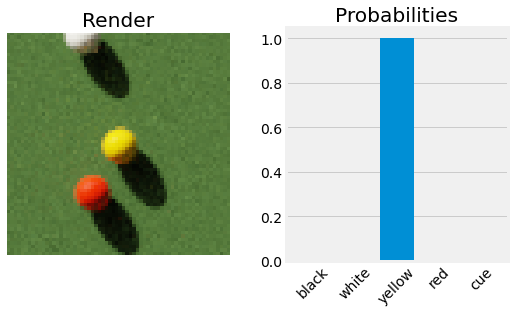

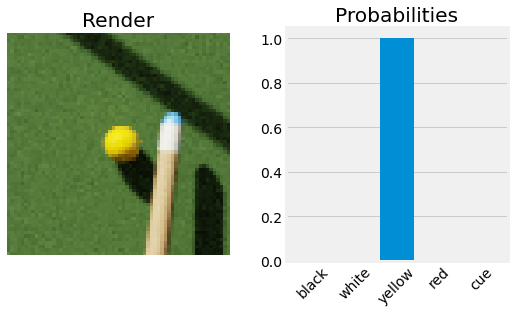

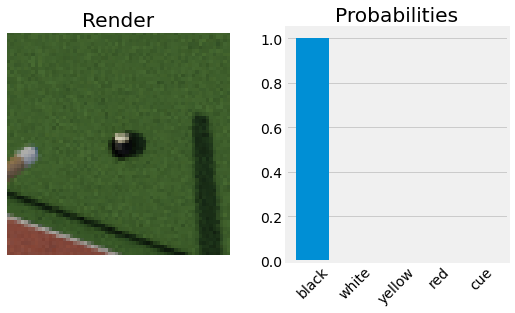

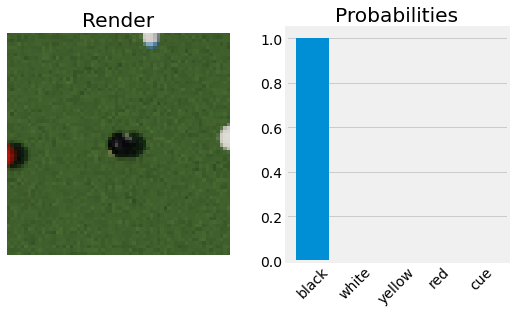

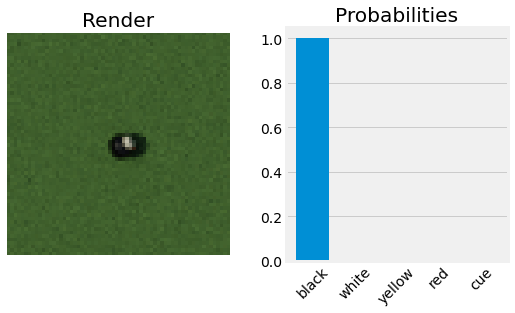

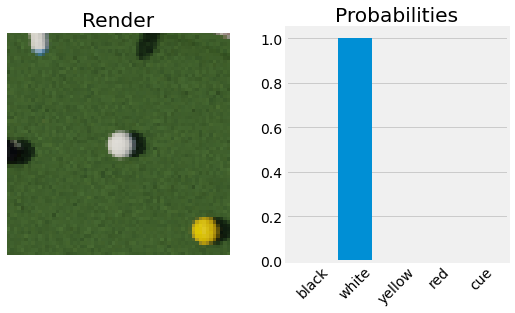

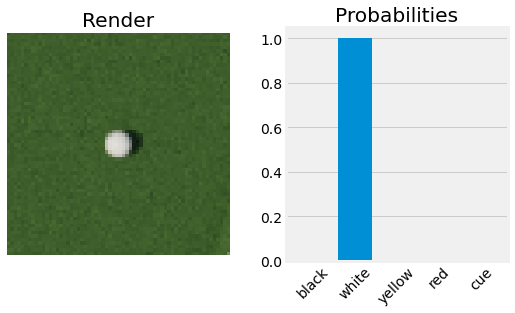

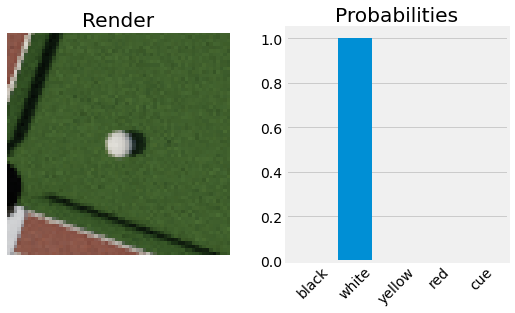

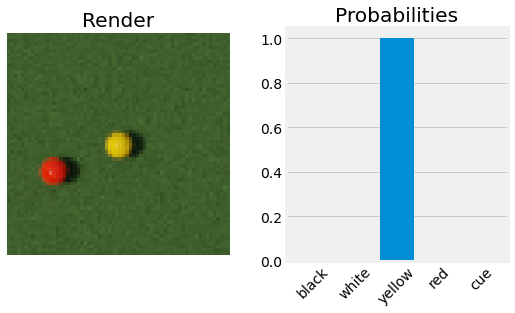

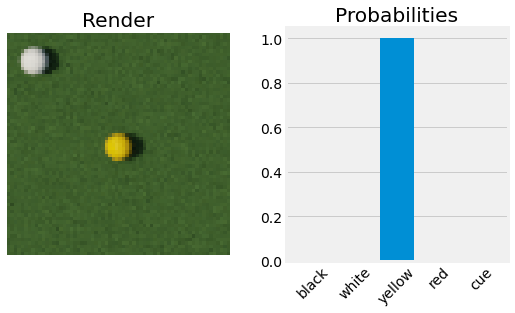

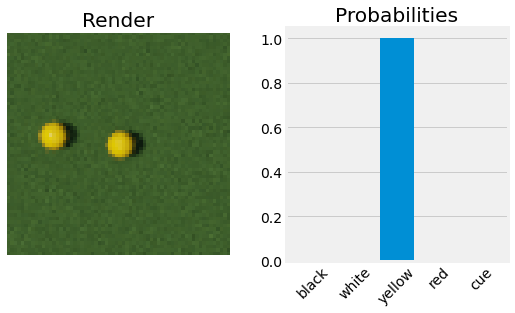

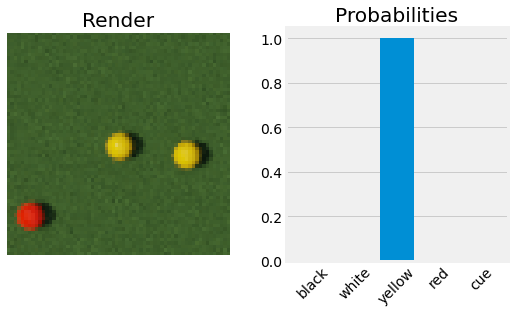

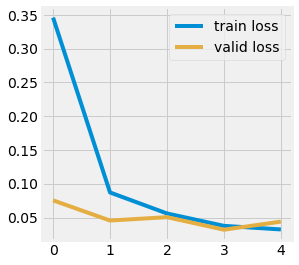

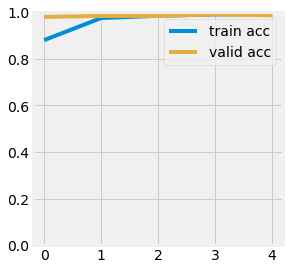

In [7]:
history_loss = {"train": [], "valid": []}
history_acc  = {"train": [], "valid": []}
for epoch in tqdm(range(EPOCHS), desc="Epoch"):
    loss, acc = step("Train", train_loader, train, is_train=True)
    history_loss["train"].append(loss)
    history_acc["train"].append(acc)
    
    with torch.no_grad():
        loss, acc = step("Valid", valid_loader, valid, is_train=False)
        plot_example(valid)
        history_loss["valid"].append(loss)
        history_acc["valid"].append(acc)
            
with torch.no_grad():
    loss, acc = step("Test", test_loader, test, is_train=False)
    plot_example(test)
        
plot_loss_history(history_loss["train"], history_loss["valid"])
plot_acc_history(history_acc["train"], history_acc["valid"])